<a href="https://colab.research.google.com/github/greyhound101/hardhat/blob/main/training_n_predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/HardHat_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
import glob
a=glob.glob('/content/annotations/*')
a[0]

'/content/annotations/hard_hat_workers4204.xml'

In [4]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [5]:
classes = ['helmet']

In [6]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]


In [7]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/content/Dataset/labels/' +  img_jpg_file_name + '.txt'
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [8]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        if cls_name=='helmet':
            x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
            y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
            x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
            y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)

            img_jpg_file_name = img_xml_file + '.jpg'
            img_box.append([cls_name, x1, y1, x2, y2])

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os

In [10]:
import os
files = os.listdir('/content/annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('/content/annotations', file_xml[0])

In [11]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/content/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 4750
train : 3800
val   : 475
test  : 475


In [12]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/content/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/content/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/content/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/content/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)
copy_data(train_list, '/content/Dataset/labels', '/content/images', "train")
copy_data(val_list,   '/content/Dataset/labels', '/content/images', "val")
copy_data(test_list,  '/content/Dataset/labels', '/content/images', "test")


Path /content/Dataset/images/train does not exit
Path /content/Dataset/labels/train does not exit
Path /content/Dataset/images/val does not exit
Path /content/Dataset/labels/val does not exit
Path /content/Dataset/images/test does not exit
Path /content/Dataset/labels/test does not exit


In [13]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 8142, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 8142 (delta 308), reused 376 (delta 259), pack-reused 7688
Receiving objects: 100% (8142/8142), 9.46 MiB | 19.80 MiB/s, done.
Resolving deltas: 100% (5604/5604), done.
/content/yolov5


In [14]:
import yaml

dict_file = {'train':'/content/Dataset/images/train' ,
            'val': '/content/Dataset/images/val',
            'nc' : '1',
            'names' : ['helmet']}

with open('/content/yolov5/data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)

In [15]:
!pip install -r /content/yolov5/requirements.txt 

     |████████████████████████████████| 645kB 7.5MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
%%writefile train.py
"""Train a YOLOv5 model on a custom dataset

Usage:
    $ python path/to/train.py --data coco128.yaml --weights yolov5s.pt --img 640
"""

import argparse
import logging
import os
import random
import sys
import time
import warnings
from copy import deepcopy
from pathlib import Path
from threading import Thread

import math
import numpy as np
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import yaml
from torch.cuda import amp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

FILE = Path(__file__).absolute()
sys.path.append(FILE.parents[0].as_posix())  # add yolov5/ to path

import val  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader
from utils.general import labels_to_class_weights, increment_path, labels_to_image_weights, init_seeds, \
    strip_optimizer, get_latest_run, check_dataset, check_file, check_git_status, check_img_size, \
    check_requirements, print_mutation, set_logging, one_cycle, colorstr
from utils.google_utils import attempt_download
from utils.loss import ComputeLoss
from utils.plots import plot_images, plot_labels, plot_results, plot_evolution
from utils.torch_utils import ModelEMA, select_device, intersect_dicts, torch_distributed_zero_first, de_parallel
from utils.wandb_logging.wandb_utils import WandbLogger, check_wandb_resume
from utils.metrics import fitness

logger = logging.getLogger(__name__)
LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))


def train(hyp,  # path/to/hyp.yaml or hyp dictionary
          opt,
          device,
          ):
    save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, = \
        opt.save_dir, opt.epochs, opt.batch_size, opt.weights, opt.single_cls, opt.evolve, opt.data, opt.cfg, \
        opt.resume, opt.noval, opt.nosave, opt.workers

    # Directories
    save_dir = Path(save_dir)
    wdir = save_dir / 'weights'
    wdir.mkdir(parents=True, exist_ok=True)  # make dir
    last = wdir / 'last.pt'
    best = wdir / 'best.pt'
    results_file = save_dir / 'results.txt'

    # Hyperparameters
    if isinstance(hyp, str):
        with open(hyp) as f:
            hyp = yaml.safe_load(f)  # load hyps dict
    logger.info(colorstr('hyperparameters: ') + ', '.join(f'{k}={v}' for k, v in hyp.items()))

    # Save run settings
    with open(save_dir / 'hyp.yaml', 'w') as f:
        yaml.safe_dump(hyp, f, sort_keys=False)
    with open(save_dir / 'opt.yaml', 'w') as f:
        yaml.safe_dump(vars(opt), f, sort_keys=False)

    # Configure
    plots = not evolve  # create plots
    cuda = device.type != 'cpu'
    init_seeds(1 + RANK)
    with open(data) as f:
        data_dict = yaml.safe_load(f)  # data dict

    # Loggers
    loggers = {'wandb': None, 'tb': None}  # loggers dict
    if RANK in [-1, 0]:
        # TensorBoard
        if not evolve:
            prefix = colorstr('tensorboard: ')
            logger.info(f"{prefix}Start with 'tensorboard --logdir {opt.project}', view at http://localhost:6006/")
            loggers['tb'] = SummaryWriter(str(save_dir))

        # W&B
        opt.hyp = hyp  # add hyperparameters
        run_id = torch.load(weights).get('wandb_id') if weights.endswith('.pt') and os.path.isfile(weights) else None
        run_id = run_id if opt.resume else None  # start fresh run if transfer learning
        wandb_logger = WandbLogger(opt, save_dir.stem, run_id, data_dict)
        loggers['wandb'] = wandb_logger.wandb
        if loggers['wandb']:
            data_dict = wandb_logger.data_dict
            weights, epochs, hyp = opt.weights, opt.epochs, opt.hyp  # may update weights, epochs if resuming

    nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
    names = ['item'] if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
    assert len(names) == nc, '%g names found for nc=%g dataset in %s' % (len(names), nc, data)  # check
    is_coco = data.endswith('coco.yaml') and nc == 80  # COCO dataset

    # Model
    pretrained = weights.endswith('.pt')
    if pretrained:
        with torch_distributed_zero_first(RANK):
            weights = attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location=device)  # load checkpoint
        model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
        exclude = ['anchor'] if (cfg or hyp.get('anchors')) and not resume else []  # exclude keys
        state_dict = ckpt['model'].float().state_dict()  # to FP32
        state_dict = intersect_dicts(state_dict, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(state_dict, strict=False)  # load
        logger.info('Transferred %g/%g items from %s' % (len(state_dict), len(model.state_dict()), weights))  # report
    else:
        model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
    with torch_distributed_zero_first(RANK):
        check_dataset(data_dict)  # check
    train_path = data_dict['train']
    val_path = data_dict['val']

    # Freeze
    freeze = []  # parameter names to freeze (full or partial)
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        if any(x in k for x in freeze):
            print('freezing %s' % k)
            v.requires_grad = False

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    logger.info(f"Scaled weight_decay = {hyp['weight_decay']}")

    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in model.named_modules():
        if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):
            pg2.append(v.bias)  # biases
        if isinstance(v, nn.BatchNorm2d):
            pg0.append(v.weight)  # no decay
        elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):
            pg1.append(v.weight)  # apply decay

    if opt.adam:
        optimizer = optim.Adam(pg0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))  # adjust beta1 to momentum
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    logger.info('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    # https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR
    if opt.linear_lr:
        lf = lambda x: (1 - x / (epochs - 1)) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear
    else:
        lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    # plot_lr_scheduler(optimizer, scheduler, epochs)

    # EMA
    ema = ModelEMA(model) if RANK in [-1, 0] else None

    # Resume
    start_epoch, best_fitness = 0, 0.0
    if pretrained:
        # Optimizer
        if ckpt['optimizer'] is not None:
            optimizer.load_state_dict(ckpt['optimizer'])
            best_fitness = ckpt['best_fitness']

        # EMA
        if ema and ckpt.get('ema'):
            ema.ema.load_state_dict(ckpt['ema'].float().state_dict())
            ema.updates = ckpt['updates']

        # Results
        if ckpt.get('training_results') is not None:
            results_file.write_text(ckpt['training_results'])  # write results.txt

        # Epochs
        start_epoch = ckpt['epoch'] + 1
        if resume:
            assert start_epoch > 0, '%s training to %g epochs is finished, nothing to resume.' % (weights, epochs)
        if epochs < start_epoch:
            logger.info('%s has been trained for %g epochs. Fine-tuning for %g additional epochs.' %
                        (weights, ckpt['epoch'], epochs))
            epochs += ckpt['epoch']  # finetune additional epochs

        del ckpt, state_dict

    # Image sizes
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    nl = model.model[-1].nl  # number of detection layers (used for scaling hyp['obj'])
    imgsz, imgsz_val = [check_img_size(x, gs) for x in opt.img_size]  # verify imgsz are gs-multiples

    # DP mode
    if cuda and RANK == -1 and torch.cuda.device_count() > 1:
        logging.warning('DP not recommended, instead use torch.distributed.run for best DDP Multi-GPU results.\n'
                        'See Multi-GPU Tutorial at https://github.com/ultralytics/yolov5/issues/475 to get started.')
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and RANK != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        logger.info('Using SyncBatchNorm()')

    # Trainloader
    dataloader, dataset = create_dataloader(train_path, imgsz, batch_size // WORLD_SIZE, gs, single_cls,
                                            hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect, rank=RANK,
                                            workers=workers,
                                            image_weights=opt.image_weights, quad=opt.quad, prefix=colorstr('train: '))
    mlc = np.concatenate(dataset.labels, 0)[:, 0].max()  # max label class
    nb = len(dataloader)  # number of batches
    assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Possible class labels are 0-%g' % (mlc, nc, data, nc - 1)

    # Process 0
    if RANK in [-1, 0]:
        valloader = create_dataloader(val_path, imgsz_val, batch_size // WORLD_SIZE * 2, gs, single_cls,
                                       hyp=hyp, cache=opt.cache_images and not noval, rect=True, rank=-1,
                                       workers=workers,
                                       pad=0.5, prefix=colorstr('val: '))[0]

        if not resume:
            labels = np.concatenate(dataset.labels, 0)
            c = torch.tensor(labels[:, 0])  # classes
            # cf = torch.bincount(c.long(), minlength=nc) + 1.  # frequency
            # model._initialize_biases(cf.to(device))
            if plots:
                plot_labels(labels, names, save_dir, loggers)
                if loggers['tb']:
                    loggers['tb'].add_histogram('classes', c, 0)  # TensorBoard

            # Anchors
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)
            model.half().float()  # pre-reduce anchor precision

    # DDP mode
    if cuda and RANK != -1:
        model = DDP(model, device_ids=[LOCAL_RANK], output_device=LOCAL_RANK)

    # Model parameters
    hyp['box'] *= 3. / nl  # scale to layers
    hyp['cls'] *= nc / 80. * 3. / nl  # scale to classes and layers
    hyp['obj'] *= (imgsz / 640) ** 2 * 3. / nl  # scale to image size and layers
    hyp['label_smoothing'] = opt.label_smoothing
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nw = max(round(hyp['warmup_epochs'] * nb), 1000)  # number of warmup iterations, max(3 epochs, 1k iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    last_opt_step = -1
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = amp.GradScaler(enabled=cuda)
    compute_loss = ComputeLoss(model)  # init loss class
    logger.info(f'Image sizes {imgsz} train, {imgsz_val} val\n'
                f'Using {dataloader.num_workers} dataloader workers\n'
                f'Logging results to {save_dir}\n'
                f'Starting training for {epochs} epochs...')
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        # Update image weights (optional)
        if opt.image_weights:
            # Generate indices
            if RANK in [-1, 0]:
                cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
                iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
                dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx
            # Broadcast if DDP
            if RANK != -1:
                indices = (torch.tensor(dataset.indices) if RANK == 0 else torch.zeros(dataset.n)).int()
                dist.broadcast(indices, 0)
                if RANK != 0:
                    dataset.indices = indices.cpu().numpy()

        # Update mosaic border
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(4, device=device)  # mean losses
        if RANK != -1:
            dataloader.sampler.set_epoch(epoch)
        pbar = enumerate(dataloader)
        logger.info(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'box', 'obj', 'cls', 'total', 'labels', 'img_size'))
        if RANK in [-1, 0]:
            pbar = tqdm(pbar, total=nb)  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            with amp.autocast(enabled=cuda):
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                if RANK != -1:
                    loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
                if opt.quad:
                    loss *= 4.

            # Backward
            scaler.scale(loss).backward()

            # Optimize
            if ni - last_opt_step >= accumulate:
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni

            # Print
            if RANK in [-1, 0]:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
                s = ('%10s' * 2 + '%10.4g' * 6) % (
                    f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1])
                pbar.set_description(s)

                # Plot
                if plots and ni < 3:
                    f = save_dir / f'train_batch{ni}.jpg'  # filename
                    Thread(target=plot_images, args=(imgs, targets, paths, f), daemon=True).start()
                    if loggers['tb'] and ni == 0:  # TensorBoard
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore')  # suppress jit trace warning
                            loggers['tb'].add_graph(torch.jit.trace(de_parallel(model), imgs[0:1], strict=False), [])
                elif plots and ni == 10 and loggers['wandb']:
                    wandb_logger.log({'Mosaics': [loggers['wandb'].Image(str(x), caption=x.name) for x in
                                                  save_dir.glob('train*.jpg') if x.exists()]})

            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        # DDP process 0 or single-GPU
        if RANK in [-1, 0]:
            # mAP
            ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'gr', 'names', 'stride', 'class_weights'])
            final_epoch = epoch + 1 == epochs
            if not noval or final_epoch:  # Calculate mAP
                wandb_logger.current_epoch = epoch + 1
                results, maps, _ = val.run(data_dict,
                                           batch_size=batch_size // WORLD_SIZE * 2,
                                           imgsz=imgsz_val,
                                           model=ema.ema,
                                           single_cls=single_cls,
                                           dataloader=valloader,
                                           save_dir=save_dir,
                                           save_json=is_coco and final_epoch,
                                           verbose=nc < 50 and final_epoch,
                                           plots=plots and final_epoch,
                                           wandb_logger=wandb_logger,
                                           compute_loss=compute_loss)

            # Write
            with open(results_file, 'a') as f:
                f.write(s + '%10.4g' * 7 % results + '\n')  # append metrics, val_loss

            # Log
            tags = ['train/box_loss', 'train/obj_loss', 'train/cls_loss',  # train loss
                    'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95',
                    'val/box_loss', 'val/obj_loss', 'val/cls_loss',  # val loss
                    'x/lr0', 'x/lr1', 'x/lr2']  # params
            for x, tag in zip(list(mloss[:-1]) + list(results) + lr, tags):
                if loggers['tb']:
                    loggers['tb'].add_scalar(tag, x, epoch)  # TensorBoard
                if loggers['wandb']:
                    wandb_logger.log({tag: x})  # W&B

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            if fi > best_fitness:
                best_fitness = fi
            wandb_logger.end_epoch(best_result=best_fitness == fi)

            # Save model
            if (not nosave) or (final_epoch and not evolve):  # if save
                ckpt = {'epoch': epoch,
                        'best_fitness': best_fitness,
                        'training_results': results_file.read_text(),
                        'model': deepcopy(de_parallel(model)).half(),
                        'ema': deepcopy(ema.ema).half(),
                        'updates': ema.updates,
                        'optimizer': optimizer.state_dict(),
                        'wandb_id': wandb_logger.wandb_run.id if loggers['wandb'] else None}

                # Save last, best and delete
                torch.save(ckpt, '/content/gdrive/MyDrive/last.pt')
                if best_fitness == fi:
                    torch.save(ckpt, '/content/gdrive/MyDrive/best.pt')
                if loggers['wandb']:
                    if ((epoch + 1) % opt.save_period == 0 and not final_epoch) and opt.save_period != -1:
                        wandb_logger.log_model(last.parent, opt, epoch, fi, best_model=best_fitness == fi)
                del ckpt

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training -----------------------------------------------------------------------------------------------------
    if RANK in [-1, 0]:
        logger.info(f'{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.\n')
        if plots:
            plot_results(save_dir=save_dir)  # save as results.png
            if loggers['wandb']:
                files = ['results.png', 'confusion_matrix.png', *[f'{x}_curve.png' for x in ('F1', 'PR', 'P', 'R')]]
                wandb_logger.log({"Results": [loggers['wandb'].Image(str(save_dir / f), caption=f) for f in files
                                              if (save_dir / f).exists()]})

        if not evolve:
            if is_coco:  # COCO dataset
                for m in [last, best] if best.exists() else [last]:  # speed, mAP tests
                    results, _, _ = val.run(data_dict,
                                            batch_size=batch_size // WORLD_SIZE * 2,
                                            imgsz=imgsz_val,
                                            model=attempt_load(m, device).half(),
                                            single_cls=single_cls,
                                            dataloader=valloader,
                                            save_dir=save_dir,
                                            save_json=True,
                                            plots=False)

            # Strip optimizers
            for f in last, best:
                if f.exists():
                    strip_optimizer(f)  # strip optimizers
            if loggers['wandb']:  # Log the stripped model
                loggers['wandb'].log_artifact(str(best if best.exists() else last), type='model',
                                              name='run_' + wandb_logger.wandb_run.id + '_model',
                                              aliases=['latest', 'best', 'stripped'])
        wandb_logger.finish_run()

    torch.cuda.empty_cache()
    return results


def parse_opt(known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default='yolov5s.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default='data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--hyp', type=str, default='data/hyps/hyp.scratch.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs')
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='[train, val] image sizes')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--noval', action='store_true', help='only validate final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable autoanchor check')
    parser.add_argument('--evolve', type=int, nargs='?', const=300, help='evolve hyperparameters for x generations')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache-images', action='store_true', help='cache images for faster training')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train multi-class data as single-class')
    parser.add_argument('--adam', action='store_true', help='use torch.optim.Adam() optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--workers', type=int, default=8, help='maximum number of dataloader workers')
    parser.add_argument('--project', default='runs/train', help='save to project/name')
    parser.add_argument('--entity', default=None, help='W&B entity')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--quad', action='store_true', help='quad dataloader')
    parser.add_argument('--linear-lr', action='store_true', help='linear LR')
    parser.add_argument('--label-smoothing', type=float, default=0.0, help='Label smoothing epsilon')
    parser.add_argument('--upload_dataset', action='store_true', help='Upload dataset as W&B artifact table')
    parser.add_argument('--bbox_interval', type=int, default=-1, help='Set bounding-box image logging interval for W&B')
    parser.add_argument('--save_period', type=int, default=-1, help='Log model after every "save_period" epoch')
    parser.add_argument('--artifact_alias', type=str, default="latest", help='version of dataset artifact to be used')
    parser.add_argument('--local_rank', type=int, default=-1, help='DDP parameter, do not modify')
    opt = parser.parse_known_args()[0] if known else parser.parse_args()
    return opt


def main(opt):
    set_logging(RANK)
    if RANK in [-1, 0]:
        print(colorstr('train: ') + ', '.join(f'{k}={v}' for k, v in vars(opt).items()))
        check_git_status()
        check_requirements(exclude=['thop'])

    # Resume
    wandb_run = check_wandb_resume(opt)
    if opt.resume and not wandb_run:  # resume an interrupted run
        ckpt = opt.resume if isinstance(opt.resume, str) else get_latest_run()  # specified or most recent path
        assert os.path.isfile(ckpt), 'ERROR: --resume checkpoint does not exist'
        with open(Path(ckpt).parent.parent / 'opt.yaml') as f:
            opt = argparse.Namespace(**yaml.safe_load(f))  # replace
        opt.cfg, opt.weights, opt.resume = '', ckpt, True  # reinstate
        logger.info('Resuming training from %s' % ckpt)
    else:
        # opt.hyp = opt.hyp or ('hyp.finetune.yaml' if opt.weights else 'hyp.scratch.yaml')
        opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
        assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
        opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, val)
        opt.name = 'evolve' if opt.evolve else opt.name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok or opt.evolve))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        from datetime import timedelta
        assert torch.cuda.device_count() > LOCAL_RANK, 'insufficient CUDA devices for DDP command'
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device('cuda', LOCAL_RANK)
        dist.init_process_group(backend="nccl" if dist.is_nccl_available() else "gloo", timeout=timedelta(seconds=60))
        assert opt.batch_size % WORLD_SIZE == 0, '--batch-size must be multiple of CUDA device count'
        assert not opt.image_weights, '--image-weights argument is not compatible with DDP training'

    # Train
    if not opt.evolve:
        train(opt.hyp, opt, device)
        if WORLD_SIZE > 1 and RANK == 0:
            _ = [print('Destroying process group... ', end=''), dist.destroy_process_group(), print('Done.')]

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (mutation scale 0-1, lower_limit, upper_limit)
        meta = {'lr0': (1, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
                'lrf': (1, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
                'momentum': (0.3, 0.6, 0.98),  # SGD momentum/Adam beta1
                'weight_decay': (1, 0.0, 0.001),  # optimizer weight decay
                'warmup_epochs': (1, 0.0, 5.0),  # warmup epochs (fractions ok)
                'warmup_momentum': (1, 0.0, 0.95),  # warmup initial momentum
                'warmup_bias_lr': (1, 0.0, 0.2),  # warmup initial bias lr
                'box': (1, 0.02, 0.2),  # box loss gain
                'cls': (1, 0.2, 4.0),  # cls loss gain
                'cls_pw': (1, 0.5, 2.0),  # cls BCELoss positive_weight
                'obj': (1, 0.2, 4.0),  # obj loss gain (scale with pixels)
                'obj_pw': (1, 0.5, 2.0),  # obj BCELoss positive_weight
                'iou_t': (0, 0.1, 0.7),  # IoU training threshold
                'anchor_t': (1, 2.0, 8.0),  # anchor-multiple threshold
                'anchors': (2, 2.0, 10.0),  # anchors per output grid (0 to ignore)
                'fl_gamma': (0, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
                'hsv_h': (1, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
                'hsv_s': (1, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
                'hsv_v': (1, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
                'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
                'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
                'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
                'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
                'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
                'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
                'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)
                'mosaic': (1, 0.0, 1.0),  # image mixup (probability)
                'mixup': (1, 0.0, 1.0),  # image mixup (probability)
                'copy_paste': (1, 0.0, 1.0)}  # segment copy-paste (probability)

        with open(opt.hyp) as f:
            hyp = yaml.safe_load(f)  # load hyps dict
            if 'anchors' not in hyp:  # anchors commented in hyp.yaml
                hyp['anchors'] = 3
        assert LOCAL_RANK == -1, 'DDP mode not implemented for --evolve'
        opt.noval, opt.nosave = True, True  # only val/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        yaml_file = Path(opt.save_dir) / 'hyp_evolved.yaml'  # save best result here
        if opt.bucket:
            os.system('gsutil cp gs://%s/evolve.txt .' % opt.bucket)  # download evolve.txt if exists

        for _ in range(opt.evolve):  # generations to evolve
            if Path('evolve.txt').exists():  # if evolve.txt exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt('evolve.txt', ndmin=2)
                n = min(5, len(x))  # number of previous results to consider
                x = x[np.argsort(-fitness(x))][:n]  # top n mutations
                w = fitness(x) - fitness(x).min() + 1E-6  # weights (sum > 0)
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

                # Mutate
                mp, s = 0.8, 0.2  # mutation probability, sigma
                npr = np.random
                npr.seed(int(time.time()))
                g = np.array([x[0] for x in meta.values()])  # gains 0-1
                ng = len(meta)
                v = np.ones(ng)
                while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                    v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                    hyp[k] = float(x[i + 7] * v[i])  # mutate

            # Constrain to limits
            for k, v in meta.items():
                hyp[k] = max(hyp[k], v[1])  # lower limit
                hyp[k] = min(hyp[k], v[2])  # upper limit
                hyp[k] = round(hyp[k], 5)  # significant digits

            # Train mutation
            results = train(hyp.copy(), opt, device)

            # Write mutation results
            print_mutation(hyp.copy(), results, yaml_file, opt.bucket)

        # Plot results
        plot_evolution(yaml_file)
        print(f'Hyperparameter evolution complete. Best results saved as: {yaml_file}\n'
              f'Command to train a new model with these hyperparameters: $ python train.py --hyp {yaml_file}')


def run(**kwargs):
    # Usage: import train; train.run(imgsz=320, weights='yolov5m.pt')
    opt = parse_opt(True)
    for k, v in kwargs.items():
        setattr(opt, k, v)
    main(opt)


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)


Overwriting train.py


In [17]:
!python train.py --img 416 --batch 32 --epochs 1 --data data/hard_head.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=1, batch_size=32, img_size=[416], rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-290-g62409ee torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, 

In [18]:
try:
    os.mkdir('test')
except:
    pass
import glob
img=glob.glob('/content/images/*')[:10]
len(img)

10

In [19]:
import shutil as sh
for i in img:
    sh.copy(i,'test')

In [23]:
%%writefile detect.py
import argparse
import sys
import time
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.backends.cudnn as cudnn

FILE = Path(__file__).absolute()
sys.path.append(FILE.parents[0].as_posix())  # add yolov5/ to path

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, colorstr, non_max_suppression, \
    apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized


@torch.no_grad()
def run(weights='yolov5s.pt',  # model.pt path(s)
        source='data/images',  # file/dir/URL/glob, 0 for webcam
        imgsz=640,  # inference size (pixels)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project='runs/detect',  # save results to project/name
        name='exp',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=3,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        ):
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(device)
    half &= device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check image size
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet50', n=2)  # initialize
        modelc.load_state_dict(torch.load('resnet50.pt', map_location=device)['model']).to(device).eval()

    # Dataloader
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
        bs = len(dataset)  # batch_size
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)
        bs = 1  # batch_size
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img,
                     augment=augment,
                     visualize=increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], f'{i}: ', im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
                        colors_tot=(np.mean(im0[c1[0]:c2[0],c1[1]:c2[1],0]),
                                    np.mean(im0[c1[0]:c2[0],c1[1]:c2[1],1]),
                                    np.mean(im0[c1[0]:c2[0],c1[1]:c2[1],2]))
                        plot_one_box(xyxy, im0, label=label, color=colors_tot, line_thickness=line_thickness)
                        if save_crop:
                            save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    if update:
        strip_optimizer(weights)  # update model (to fix SourceChangeWarning)

    print(f'Done. ({time.time() - t0:.3f}s)')


def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default='yolov5s.pt', help='model.pt path(s)')
    parser.add_argument('--source', type=str, default='data/images', help='file/dir/URL/glob, 0 for webcam')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default='runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    opt = parser.parse_args()
    return opt


def main(opt):
    print(colorstr('detect: ') + ', '.join(f'{k}={v}' for k, v in vars(opt).items()))
    check_requirements(exclude=('tensorboard', 'thop'))
    run(**vars(opt))


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)

Overwriting detect.py


In [24]:
!python detect.py --source test  --weights /content/gdrive/MyDrive/last.pt --conf 0.25

detect: weights=['/content/gdrive/MyDrive/last.pt'], source=test, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-290-g62409ee torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/10 /content/yolov

<function matplotlib.pyplot.show>

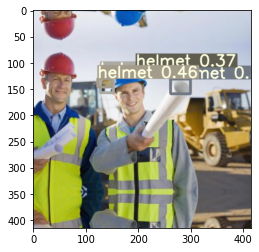

In [25]:
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp2/*')

img = plt.imread(testfiles[3]) 
plt.imshow(img)    
plt.show